# Exploration and Clustering of the Deutsche Bahn (DB) Data (Stations Dataset)

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Import libraries and load the dataset</a></li>
        <li><a href="#ref2">Quick data preparation</a></li>
        <li><a href="#ref3">Perform visualization and data exploration</a></li>
        <li><a href="#ref4">Perform clustering on the stations</a></li>
        <li><a href="#ref5">Conclusion</a></li>
    </ol>
</div>
<br>
<hr>  

<h2>
<div class="alert alert-danger"" style="margin-top: 20px">
          If the map could NOT be opened, Please view the notebook via Jupyter nbviewer by <br> <a href="https://nbviewer.jupyter.org/github/Abdurahman-Amat/ds_projects/blob/master/DB_stations_dataset_analysis_clustering.ipynb" target="_blank">clicking here </a>, thank you!!!
</div>
</h2>


<hr>

<a id="ref1"></a>
# Import libraries and load the dataset  

In [20]:
import numpy as np
import pandas as pd
import folium # map rendering library
# import k-means from clustering stage
from scipy.spatial.distance import cdist 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# data_path = '\data\D_Bahnhof_2020_alle.csv'
# this and more otehr datasets are also acceeable via DB API. Here I just used provided CSV file directly.
# data source:
#  url = 'https://data.deutschebahn.com/dataset/data-haltestellen'
# the decimal ',' must be passed for German numbers which use comma as decimal marker instead of point
df = pd.read_csv('data\D_Bahnhof_2020_alle.csv', sep=';', decimal=',')
df.head()

,EVA_NR,DS100,IFOPT,NAME,Verkehr,Laenge,Breite,Betreiber_Name,Betreiber_Nr,Status
0,8002551,AELB,de:02000:11943,Hamburg Elbbrücken,RV,10.024500,53.534500,DB Station und Service AG,NaN,neu
1,8001944,TETN,NaN,Eutingen Nord,RV,8.753100,48.484700,DB Station und Service AG,NaN,neu
2,8003074,MIA,NaN,Ingolstadt Audi,RV,11.407456,48.790496,DB Station und Service AG,NaN,neu
3,8001723,HEBA,NaN,Einbeck Otto-Hahn-Straße,RV,9.892910,51.814478,Ilmebahn GmbH,NaN,neu
4,8004371,KRO,NaN,Nörvenich-Rommelsheim,nur DPN,6.547586,50.782539,Rurtalbahn GmbH,NaN,neu


In [22]:
df.shape

(6519, 10)

So, the loading the dataset is successfull. We can see that there are totally 6519 Deutsche Bahn (DB) Stations are listed in this dataset. Each entry has 10 features. The meaning of each feature is explined shortly on the official DB site for this dataset and as given below in German.

**Langbeschreibung**

In den veröffentlichten Daten sind zu jeder Haltestelle folgende Informationen enthalten:

    EVA_NR:   Nummer der Haltestelle, z. B. 8000001.
    DS100: Verweis auf Betriebsstelle, z. B. KA.
    IFOPT: Deutschlandweiter, einheitlicher Haltestellenschlüssel, z. B. de:05334:1008
    NAME: Name der Haltestelle, z. B. Aachen Hbf.
    VERKEHR: Kann folgende Werte annehmen 'FV' (mit Fernverkehr), 'RV' (nur Regionalverkehr) oder 'nur DPN' (nur Regionalverkehr von privaten Eisenbahnunternehmen).
    LAENGE: Longitude der Haltestelle in WGS84, z. B. 6.091499.
    BREITE: Latitude der Haltestelle in WGS84, z. B. 50.7678.
    BETREIBER_NAME: Betreibername der Haltestelle, z. B. DB Station & Ser-vice AG.
    BETREIBER_NR: Bahnhofsnummer aus dem Stationsdatensatz. Nur für Stationen von DB Station & Service, z. B. 4.
    STATUS: Hinweis, meist nicht verwendet z. B. neu



<a id="ref2"></a>
# Quick data preparation 

First I will replace feature names into more readable form in English.

In [23]:
new_df = df.rename(columns={"EVA_NR":"Station Nr", "DS100":"Operation Site Ref", "IFOPT":"Stop Key", "NAME":"Name", 
                            "Verkehr":"Traffic", "Regionalverkehr":"Regional Traffic", "Laenge":"Longitude", 
                            "Breite":"Latitude", "Betreiber_Name":"Operator Name", "Betreiber_Nr":"Station Service Nr", "Status":"Note"})
new_df.head()

,Station Nr,Operation Site Ref,Stop Key,Name,Traffic,Longitude,Latitude,Operator Name,Station Service Nr,Note
0,8002551,AELB,de:02000:11943,Hamburg Elbbrücken,RV,10.024500,53.534500,DB Station und Service AG,NaN,neu
1,8001944,TETN,NaN,Eutingen Nord,RV,8.753100,48.484700,DB Station und Service AG,NaN,neu
2,8003074,MIA,NaN,Ingolstadt Audi,RV,11.407456,48.790496,DB Station und Service AG,NaN,neu
3,8001723,HEBA,NaN,Einbeck Otto-Hahn-Straße,RV,9.892910,51.814478,Ilmebahn GmbH,NaN,neu
4,8004371,KRO,NaN,Nörvenich-Rommelsheim,nur DPN,6.547586,50.782539,Rurtalbahn GmbH,NaN,neu


It is now OK.

Lets retrieve the information of the Station at Marburg(Lahn) where I am currently living.

In [24]:
new_df[new_df['Name']=='Marburg(Lahn)']

,Station Nr,Operation Site Ref,Stop Key,Name,Traffic,Longitude,Latitude,Operator Name,Station Service Nr,Note
328,8000337,FMBG,de:06534:10011,Marburg(Lahn),FV,8.775014,50.819272,DB Station und Service AG,3943.0,NaN


In [25]:
# Geolocation of Marburg(Lahn)
longitude_MR = new_df[new_df['Name']=='Marburg(Lahn)'][["Longitude"]].values[0][0]
latitude_MR = new_df[new_df['Name']=='Marburg(Lahn)'][["Latitude"]].values[0][0]

print(f'Longitude : {longitude_MR}, Latitude : {latitude_MR}')

Longitude : 8.775014, Latitude : 50.819272


Quick check the geolocation if everything is going well.

In [26]:
# Plot on the map
map_Marburg = folium.Map(location=[latitude_MR, longitude_MR], zoom_start=12)
map_Marburg

Now let's check if there are any missing values in the data. 

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519 entries, 0 to 6518
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station Nr          6519 non-null   int64  
 1   Operation Site Ref  6519 non-null   object 
 2   Stop Key            6512 non-null   object 
 3   Name                6519 non-null   object 
 4   Traffic             6519 non-null   object 
 5   Longitude           6519 non-null   float64
 6   Latitude            6519 non-null   float64
 7   Operator Name       6517 non-null   object 
 8   Station Service Nr  5395 non-null   float64
 9   Note                24 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 509.4+ KB


visually observe above result and get more insight about the missing / nan values within the dataset.

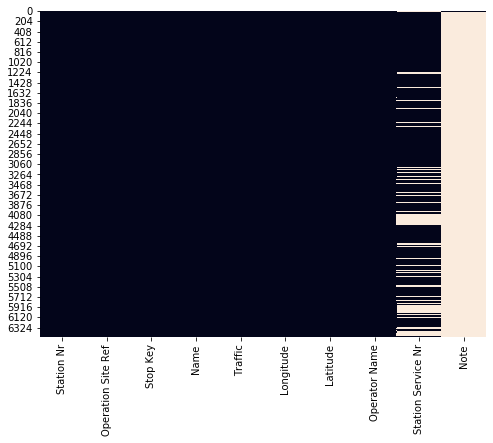

In [28]:
plt.subplots(figsize=(8, 6))
sns.heatmap(new_df.isnull(), cbar=False)

First of all, drop the Note column which is almost with Nan values.  
There are around 1000 missing values in Station service Nr column.   
Since it is like a reference number, we can drop it and just use the Stration Nr at teh first column.

In [29]:
new_df.drop(['Station Service Nr', 'Note'], axis=1, inplace=True)
new_df.head()

,Station Nr,Operation Site Ref,Stop Key,Name,Traffic,Longitude,Latitude,Operator Name
0,8002551,AELB,de:02000:11943,Hamburg Elbbrücken,RV,10.024500,53.534500,DB Station und Service AG
1,8001944,TETN,NaN,Eutingen Nord,RV,8.753100,48.484700,DB Station und Service AG
2,8003074,MIA,NaN,Ingolstadt Audi,RV,11.407456,48.790496,DB Station und Service AG
3,8001723,HEBA,NaN,Einbeck Otto-Hahn-Straße,RV,9.892910,51.814478,Ilmebahn GmbH
4,8004371,KRO,NaN,Nörvenich-Rommelsheim,nur DPN,6.547586,50.782539,Rurtalbahn GmbH


In [30]:
new_df.isnull().sum()

Station Nr            0
Operation Site Ref    0
Stop Key              7
Name                  0
Traffic               0
Longitude             0
Latitude              0
Operator Name         2
dtype: int64

In [31]:
# drop all rows with any NaN and missing values
new_df = new_df.dropna()
new_df.isnull().sum()

Station Nr            0
Operation Site Ref    0
Stop Key              0
Name                  0
Traffic               0
Longitude             0
Latitude              0
Operator Name         0
dtype: int64

Now the dataset is ready to be further prrocessed.

<a id="ref3"></a>
# Perform visualization and data exploration  

I am living in Germany almost five years and I only know the DB and the HLB. I would like to know if there are any other companies who are operating.

In [32]:
new_df['Operator Name'].value_counts()

DB Station und Service AG                                       5399
DB RegioNetz Infrastruktur GmbH                                  245
Albtal-Verkehrs-Gesellschaft mbH                                 179
Harzer Schmalspurbahnen GmbH                                      47
AKN Eisenbahn AG                                                  46
SWEG Schienenwege GmbH                                            42
Rurtalbahn GmbH                                                   40
City-Bahn Chemnitz GmbH                                           39
Hohenzollerische Landesbahn AG                                    33
Sächsische Dampfeisenbahngesellschaft mbH                         30
Usedomer Bäderbahn GmbH                                           28
Regio Infra Nord-Ost GmbH & Co. KG                                26
Erms-Neckar-Bahn AG                                               25
Eisenbahnen und Verkehrsbetriebe Elbe-Weser GmbH                  24
Niederbarnimer Eisenbahn AG       

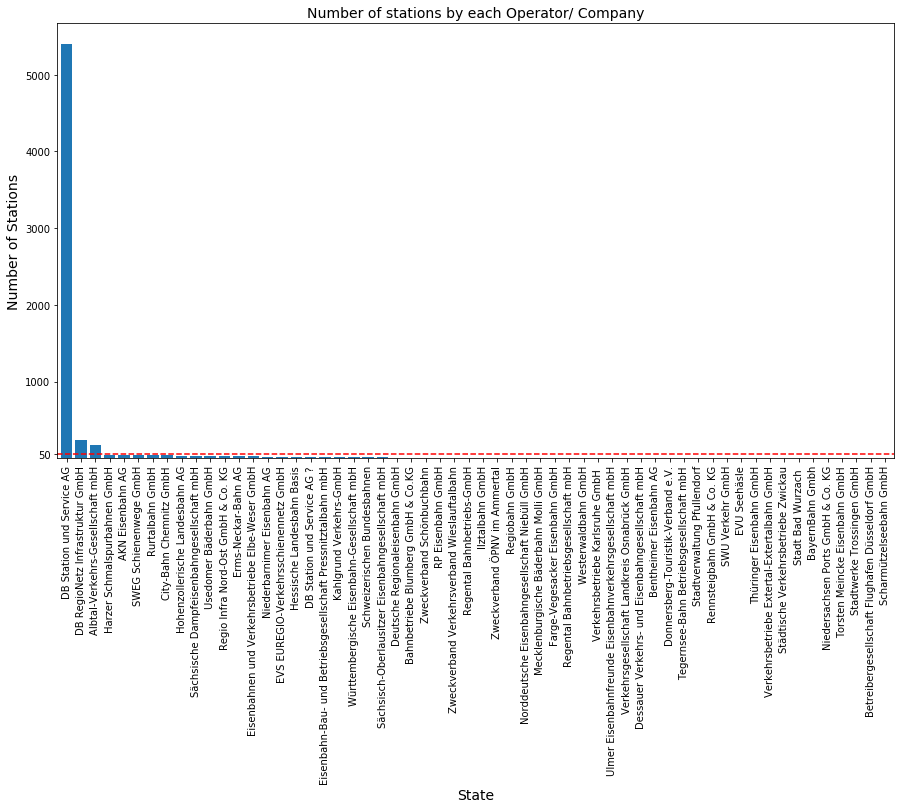

In [33]:
operator_name_df = new_df['Operator Name'].value_counts().to_frame()
# plot data in bar chart
operator_name_df.plot(kind='bar', width=0.8, figsize=(15, 8), legend=False)
plt.axhline(y=50, linewidth=1.5, color='r', linestyle='--')
plt.yticks([50, 1000, 2000, 3000, 4000, 5000], ['50', '1000', '2000', '3000', '4000', '5000'])
plt.xlabel('State', fontsize=14) # add to x-label to the plot
plt.ylabel('Number of Stations', fontsize=14) # add y-label to the plot
plt.title('Number of stations by each Operator/ Company', fontsize=14) # add title to the plot
plt.show()

From above exploration, we knew that there are 58 Train station operators in Germany. Amogn them the Deutsche Bahn (DB) is the biggest Operator as known so by amost everyone in Germany. Except DB there are 57 Operators have few number of operating points ranges from 1 to ~250.

<a id="ref4"></a>
# Perform clustering on the stations

In [34]:
# This below sell will be usefull when whe wanna know the structure of stations  
# in subdatasets like 'FV', 'RV' and 'nur DPN' for the traffic type.
# fv_filter = new_df['Traffic'].isin(['FV', 'nur DPN'])
# new_df = new_df[fv_filter]

In this part I would like to use the unsupervised machine learning algotihm KMeans clustering. KMeans clustering is the mostly used unsupervised machine learning classification algorithm. It is fast and firt-step-try kind method.  
- To find out the optimal number of cluster, the K value, in the KMeans clustering I will use two metrics methods, namely Elbow method and Silhouette Analysis
- To visually demonstrate the clusters I will plot all DB Station clusters superimposed on the map Germany.


### Elbow Method

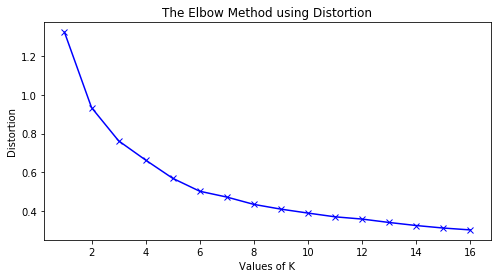

In [35]:
loc_df = new_df[["Longitude", "Latitude"]]
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,17) 
# Standardize the data
X = StandardScaler().fit_transform(loc_df)

for k in K: 
	#Building and fitting the model 
	kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X) 
	kmeanModel.fit(X)	 
	
	distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
					'euclidean'),axis=1)) / X.shape[0]) 
	inertias.append(kmeanModel.inertia_) 

	mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
				'euclidean'),axis=1)) / X.shape[0] 
	mapping2[k] = kmeanModel.inertia_ 
    
# ploting
plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

The elbow method did not give quite noticeable elbow, but just a monoton decreasing in the Distortion with the increasing number of klasters K.  
It might be useful to calculate the **Silhouette coefficient** to make it easier to determine the number of clusters. The Silhouette coefficient takes value from -1 to 1 such that value larger than zero to closer to one is better. positive value closer to one, indicates that the inter cluster entries are well seperated.

---

### Silhouette Analysis

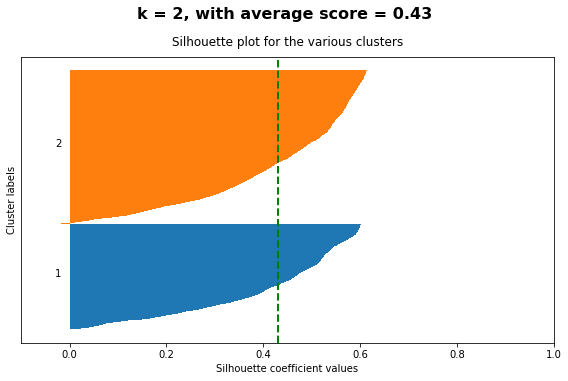

In [ ]:
for i, k in enumerate([2, 6]):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8,  5)
    
    # Build the Kmeans model 
    km = KMeans(n_clusters=k, random_state=0)
    # Fit the model to the data
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    plt.tight_layout()
    plt.suptitle(f'k = {k}, with average score = {avg_score:.2f}',
                 fontsize=16, fontweight='semibold', y=1.05);

## Now plot these two clusters superimposed on the map of Germany. 

### K=2

In [ ]:
loc_df = new_df[["Longitude", "Latitude"]]

# set number of clusters, since there are four Boroughs with the names including the word Toronto
kclusters = 2
# K-means clustering does not work well with categorical features, so drop them
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
#len(kmeans.labels_)#[0:10] 
loc_df.insert(0, 'Cluster Labels', kmeans.labels_)

# Plot on the map
map_Marburg = folium.Map(location=[latitude_MR, longitude_MR], zoom_start=6)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
gist_rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(loc_df['Latitude'], loc_df['Longitude'], loc_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color=gist_rainbow[cluster-1],
        fill=True,
        fill_color=gist_rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_Marburg)
       
map_Marburg

### K=6

In [ ]:
loc_df = new_df[["Longitude", "Latitude"]]
# set number of clusters, since there are four Boroughs with the names including the word Toronto
kclusters = 6
# K-means clustering does not work well with categorical features, so drop them
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
len(kmeans.labels_)#[0:10] 

loc_df.insert(0, 'Cluster Labels', kmeans.labels_)

# Plot on the map
map_Marburg = folium.Map(location=[latitude_MR, longitude_MR], zoom_start=6)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
gist_rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(loc_df['Latitude'], loc_df['Longitude'], loc_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color=gist_rainbow[cluster-1],
        fill=True,
        fill_color=gist_rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_Marburg)
           
map_Marburg

---

<a id="ref5"></a>
# Conclusion

In this Notebook I have tried to understand the Deutsche Bahn (DB) Stations dataset.  
- First of all I have found the data by searching the Internet and loaded it into this Notebook for further processing.  
- Secondly, I have did some basic data prepation and cleaning.  
- Thirdly, I have performed data exploration on one feature of it.  
- At the end, I tried to cluster these train stations by their geolocations with the help of unsupervised machine learning  
algotihm KMean clustering. Since the train stations are located quite nearby. Novertheless, as a preliminary approach  
this clustering result showed that one can might classify them into two clusters or six clusters. 
- Last but not least, this kind of classifying may give some hint when Deutsche Bahn (DB) is planning to test some projects. For instance, it is better and cost effective to implement some price changing or some kind of new costumer services at smaller scale, in one or two of these class of regions instead of implementing at all stations nationwide. Off course, this kind of classification may give more insights in the decision making process when we analyzie together with other datasets about ticket price, costumer comments, quality of local infrastructure etc.  

--- The End ---